In [1]:
from itertools import product, islice
from typing import Dict, List, Any, Tuple, Callable
import os
import pickle
from timeit import default_timer as timer
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial import distance

from IOData.IOData import InputRule
from IOData.IODataWith_l import IODataWith_l

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType
from tools.simualtion_results import Results

from tools.simple_track_generator import trackGenerator
from tools.FractalDimension import fractal_dimension
from tools.monte_carlo_integral import monte_carlo_integrate
from tools.dataset_analyse import weighting_xi_in_datasets, weighting_u_pf_y_p_in_datasets, get_datasets_hankel_matrix, Sampler, from_deg_to_rad

In [2]:
# read results from file
results_file_name = '09-20_14_17-results_list.pkl'
with open(os.path.join(os.curdir, 'datasets', results_file_name), 'rb') as f:
    results_list: List[Results] = pickle.load(f)

In [3]:
dataset_name_list: List[str]  = [
    '09-20-11-07-14-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-08-43-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-09-27-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-09-44-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-10-32-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-10-42-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-14-28-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-18-57-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-40-18-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-40-41-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-48-02-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-11-50-16-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-12-43-52-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-12-58-02-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-14-08-04-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-14-10-34-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-14-15-40-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
    '09-20-14-17-14-oval_track-INDIRECT_FIX_MU_WEIGHTING_ADD_DATA.pkl',
]

In [4]:
len(dataset_name_list)

18

In [5]:
for result in results_list:
    print(result.mark_time_steps)
    # print([traj_slice[0] for traj_slice in result._error_trajectory_slices])
print(round(5.32/0.01)-1)

[539, 523, 503]
[]
[551, 535, 515]
[159, 143, 123]
[531, 515, 495]
[55, 39, 19]
[55, 39, 19]
[547, 531, 511]
[571, 555, 535]
[151, 135, 115]
[551, 535, 515]
[151, 135, 115]
[687, 671, 651]
[551, 535, 515]
[543, 527, 507]
[679, 663, 643]
[]
[943, 927, 907]
531


In [6]:
# parameters for analysis stored in Sampler
sampler = Sampler()
sampler.l_p = 10
sampler.l_f = 85

# results and dataset index to analyse
results_index = range(3, 18, 3)
dataset_list: List[List[List[IODataWith_l]]] = []
for i in results_index:
    with open(os.path.join(os.curdir, 'datasets', dataset_name_list[i]), 'rb') as f:
        single_dataset_list: List[List[IODataWith_l]] = pickle.load(f)
    dataset_list.append(single_dataset_list)

# get output and input size
m = dataset_list[0][0][0]._input_data[0].shape[0]
p = dataset_list[0][0][0]._output_data[0].shape[0]

# extended state to analyse
state_index = 159
results = results_list[results_index[0]]
t_proposed = (state_index+1) * results.Ts
u_list, y_list = [], []
for i in range(state_index-sampler.l_p+1, state_index+1):
    u_list.append(results._input_applied[i])
    y_list.append(from_deg_to_rad(results._error_trajectory[i][:p]))
xi_to_analyse = np.hstack(u_list + y_list)
# print(xi_to_analyse)

# extended state with future input to analyse. use the 
u_future_list = []
index_proposed = [trajectory_slice[0] for trajectory_slice in results._proposed_input_slices].index(t_proposed)
list_proposed_u = results._proposed_input_slices[index_proposed][1]
for i in range(sampler.l_f):
    u_future_list.append(list_proposed_u[i])
u_pf_y_p_to_analyse = np.hstack(u_list + u_future_list + y_list)
# print(u_pf_y_p_to_analyse)

# index of segment to analyse
i_seg = results._segment_index_list[state_index]
print(i_seg)

results_list_to_analyse = [results_list[i] for i in results_index]
dataset_list_to_analyse = dataset_list

1


(2852, 4)
1.4275927646748308


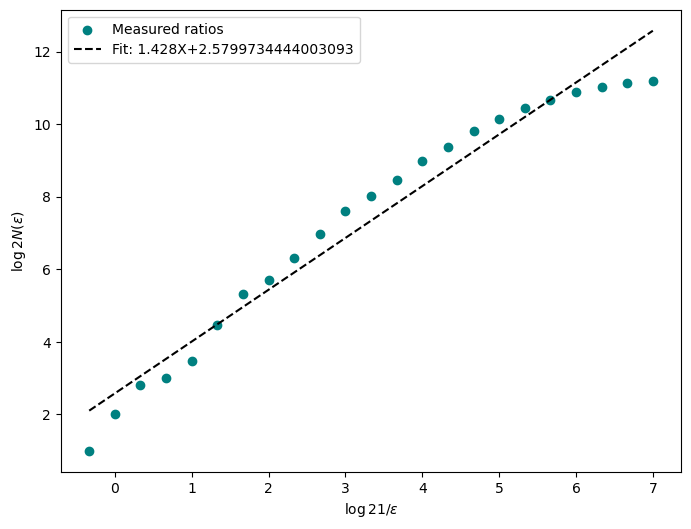

In [22]:
lag_fractal = 1
L_fractal = 0
dataset_list_for_seg = dataset_list_to_analyse[-1][i_seg]
H_uy_noised, _ = get_datasets_hankel_matrix(dataset_list_for_seg, lag=lag_fractal, L=L_fractal)
locs = np.array(H_uy_noised[m:].T)
print(locs.shape)
# plt.plot(locs[:,0], locs[:,1])

region_min = np.min(locs, axis=0)
region_max = np.max(locs, axis=0)

d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=1, min_box_size=-7, n_samples=25, n_offsets=30, plot=True)
print(d)

1.651669115824414


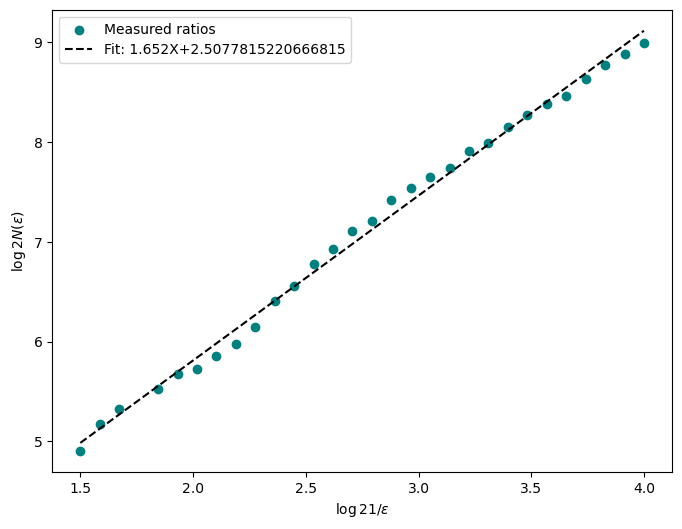

In [26]:
d, log_N, log_inverse_size = fractal_dimension(locs=locs, region_min=region_min, region_max=region_max, max_box_size=-1.5, min_box_size=-4.0, n_offsets=50, n_samples=30, plot=True)
print(d)

In [7]:
# parameters used for analysing dataset

size_xi = len(xi_to_analyse)
size_uy = len(u_pf_y_p_to_analyse)

W_xi = np.matrix(np.eye(size_xi))
W_uy = np.matrix(np.eye(size_uy))
f = lambda x: 0.01/x

lag = 10
L = 85

weighting_xi_list: List[float] = []
weighting_uy_list: List[float] = []
for dataset_list_for_track in dataset_list:
    dataset_list_for_seg = dataset_list_for_track[i_seg]
    print([data.length for data in dataset_list_for_seg])

    # evalueate the weighting matrix for xi
    weighting_xi = weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=xi_to_analyse)
    weighting_xi_list.append(weighting_xi)
    print(f"The weight of xi: {weighting_xi}")

    # evalueate the weighting matrix for u_pf_y_p
    weighting_uy = weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=u_pf_y_p_to_analyse)
    weighting_uy_list.append(weighting_uy)
    print(f"The weight of u_pf_y_p: {weighting_uy}")

    # try monte carlo integral
    # start = timer()
    values = []
    errors = []
    for _ in range(1):
        integrand = lambda x: weighting_xi_in_datasets(W_xi=W_xi, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, xi=x)
        value, error = monte_carlo_integrate(integrand, sampler.xi_iterator(), 100)
        values.append(value)
        errors.append(error)
    print(f"Value for xi integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for xi integral: {end-start}")

    # start = timer()
    values = []
    errors = []
    for _ in range(1):
        integrand = lambda x: weighting_u_pf_y_p_in_datasets(W=W_uy, f=f, io_data_list=dataset_list_for_seg, lag=lag, L=L, l_p=sampler.l_p, l_f=sampler.l_f, u_pf_y_p=x)
        value, error = monte_carlo_integrate(integrand, sampler.u_pf_y_p_iterator(), 100)
        values.append(value)
        errors.append(error)
    print(f"Value for u_pf_y_p integral: {values}, error: {errors}")
    # end = timer()
    # print(f"Time for u_pf_y_p integral: {end-start}")
    print("--------------------------------------------------")


[1000, 196, 140, 140, 156, 16]
The weight of xi: 0.5343227185316545
The weight of u_pf_y_p: 0.1503372201405862
Value for xi integral: [10.441109660786786], error: [0.2429260601474776]
Value for u_pf_y_p integral: [1.4963944420000264], error: [0.014110657244999122]
--------------------------------------------------
[1000, 196, 140, 140, 156, 16, 140]
The weight of xi: 0.6211660704541004
The weight of u_pf_y_p: 0.15547325190514194
Value for xi integral: [10.563493443181079], error: [0.26229875338462333]
Value for u_pf_y_p integral: [1.5477281677016292], error: [0.015430647038789096]
--------------------------------------------------
[1000, 196, 140, 140, 156, 16, 140, 144, 156]
The weight of xi: 0.7586601409652871
The weight of u_pf_y_p: 0.16697486082923246
Value for xi integral: [12.249214571873738], error: [0.340375716151949]
Value for u_pf_y_p integral: [1.7178654549297356], error: [0.01676351449537199]
--------------------------------------------------
[1000, 196, 140, 140, 156, 16, 